In [1]:
import numpy as np
import pandas as pd
import warnings; warnings.simplefilter('ignore')
# plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model

In [2]:
#sqqq and tqqq are taken as IBdata feed not for SPXS 
path = '/home/octo/Dropbox/IQ_data/'
spy=pd.read_csv(path + 'SPY.csv',names = ["high", "low", "open","close","total_volume","volume"],index_col=0, parse_dates=True)
sqqq= pd.read_csv(path + 'SQQQ.csv',names = ["high", "low", "open","close","total_volume","volume"],index_col=0, parse_dates=True)
tqqq=pd.read_csv(path + 'TQQQ.csv',names = ["high", "low", "open","close","total_volume","volume"],index_col=0, parse_dates=True)
spy=spy.tail(140000)
sqqq=sqqq.tail(140000)
tqqq=tqqq.tail(140000)

In [3]:
#df for datascience
df=pd.DataFrame(data=spy.open)

In [4]:
#df['time']=df.index.strftime('%H:%M:%S')
time=df.index.strftime('%H:%M:%S')

### Signal

In [5]:
P=(spy.high+spy.low+spy.close)/3
vwap=pd.rolling_sum(spy.volume*P,12)/pd.rolling_sum(spy.volume,12)
df['spread']=pd.rolling_sum(pd.DataFrame(data=(spy.open-vwap)),60)

In [6]:
df['UT']=(pd.rolling_max(spy.high,60)+pd.rolling_max(P+spy.high-spy.low,60))*0.5-0.02
df['DT']=(pd.rolling_min(spy.low,60)+pd.rolling_min(P+spy.high-spy.low,60))*0.5+0.02
df['BS']=np.where(df.open<=df.DT,1,np.where(df.open>=df.UT,-1,0))

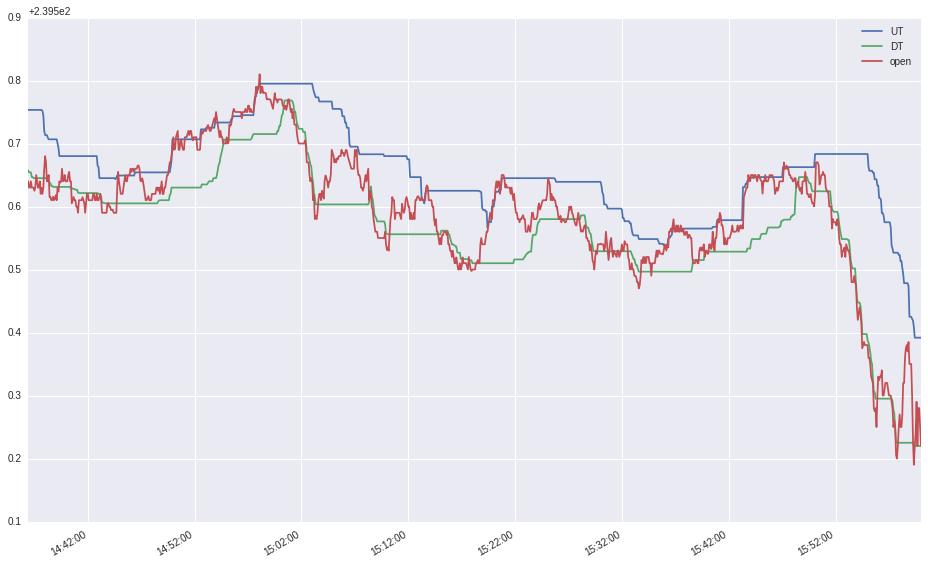

In [7]:
df[['UT','DT','open']].tail(1000).plot(figsize=(16, 10))
plt.show()

In [8]:
# reversal, when market up or down
df['NL']=pd.rolling_sum(pd.DataFrame(data=spy.open-spy.close.shift(60)),12)

In [9]:
df['speed']=pd.rolling_sum(pd.DataFrame(data=(spy.open-spy.close.shift(1))),60)

In [10]:
# difference at '09:30:05' from last day close
EO=np.where(time=='09:30:05',df.open-spy.close.shift(1),0)
df['EO']=np.where(time=='09:30:05',df.open-spy.close.shift(1),0)     
df['EO']=df.EO.replace(to_replace=0, method='ffill')

In [11]:
H=pd.rolling_max(spy.high,4600)
L=pd.rolling_min(spy.low,4600)
M=(H+L)/2
df['OF']=np.where(time=='09:30:05',df.open,0)
df['OF']=df.OF.replace(to_replace=0, method='ffill')
df['OD']=df.open-df.OF

In [12]:
df['S']=df.OD/df.EO

In [13]:
p60=pd.DataFrame(data=spy.close.shift(60))
df=df.tail(130000)

In [14]:
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(pd.DataFrame(spy.open.tail(130000)),pd.DataFrame(p60.tail(130000)))
df['pr']=regr.predict(pd.DataFrame(p60.tail(130000)))

In [15]:
df['err']=df.open-df.pr

In [16]:
df=df.dropna()

In [17]:
# reduce dataset based Market state change
df=df[df.BS!=0] # all decision when volume above 30% or vol==1
df=df.dropna()

In [18]:
df['BS1']=df.BS.shift(1)
df=df.dropna()

In [19]:
df['bs']=df.BS-df.BS1

In [20]:
# reduce dataset based Market state change
df=df[df.bs!=0] # all decision when volume above 30% or vol==1
df=df.dropna()

In [21]:
df_ml=pd.DataFrame(data=spy.open)
df_ml['BS']=df.BS
df_ml['S']=df.S
df_ml['R']=df.NL
df_ml['speed']=df.speed
df_ml['spread']=df.spread
df_ml['e']=df.err

In [22]:
df_ml=df_ml.dropna()

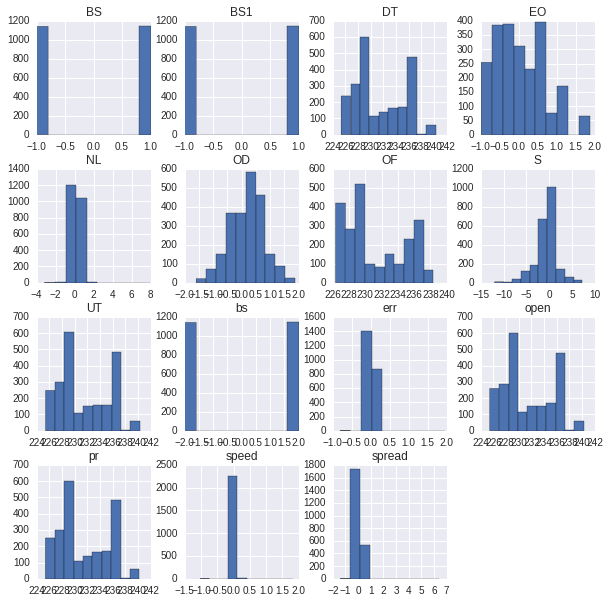

In [23]:
pd.DataFrame.hist(df, figsize = [10,10]);

In [24]:
#X=pd.DataFrame(df_svm[['volume_u','volume_d','ret_p','ret_n','Volatility','momentum','RSI']])
X=pd.DataFrame(df_ml[['speed','spread','e','S','R']])
y=pd.DataFrame(df_ml[['BS']])

In [25]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## SVM

In [26]:
from sklearn import svm
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm_model = svm.fit(X_train, y_train)
print('SVC accuracy for test set: %f' % svm_model.score(X_test, y_test))

SVC accuracy for test set: 0.853392


/home/octo/anaconda2/envs/PyAlgo/lib/python2.7/site-packages/sklearn/svm/base.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


In [27]:
from sklearn.metrics import classification_report
y_true, y_pred = y_test,svm_model.predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

       -1.0       0.88      0.83      0.85       229
        1.0       0.83      0.88      0.86       228

avg / total       0.85      0.85      0.85       457



In [43]:
X1=pd.DataFrame(df_ml[['speed','spread','e','S','R']]).tail(10)
Y1=svm_model.predict(X1)

In [29]:
df_ml.BS.tail(10)

2017-03-01 14:55:30   -1
2017-03-01 15:00:25    1
2017-03-01 15:13:15   -1
2017-03-01 15:14:50    1
2017-03-01 15:19:35   -1
2017-03-01 15:26:05    1
2017-03-01 15:36:00   -1
2017-03-01 15:38:40    1
2017-03-01 15:41:00   -1
2017-03-01 15:48:20    1
Name: BS, dtype: float64

In [32]:
df.head(10)

,open,spread,UT,DT,BS,NL,speed,EO,OF,OD,S,pr,err,BS1,bs
2017-01-19 10:59:55,226.4600,0.171430,226.450667,226.398200,-1,0.3075,-0.0176,0.1,226.84,-0.3800,-3.800,226.419314,0.040686,1,-2
2017-01-19 11:00:10,226.3400,0.139562,226.450667,226.378200,1,0.1625,-0.0138,0.1,226.84,-0.5000,-5.000,226.439292,-0.099292,-1,2
2017-01-19 11:09:20,226.2400,0.105898,226.236667,226.101667,-1,-0.4505,0.0150,0.1,226.84,-0.6000,-6.000,226.239512,0.000488,1,-2
2017-01-19 11:12:20,226.1900,0.308184,226.258333,226.217500,1,0.7043,-0.0003,0.1,226.84,-0.6500,-6.500,226.199556,-0.009556,-1,2
2017-01-19 11:15:15,226.3100,0.411546,226.301700,226.188900,-1,0.4198,0.0487,0.1,226.84,-0.5300,-5.300,226.248702,0.061298,1,-2
2017-01-19 11:25:25,226.4465,-0.086581,226.528400,226.460333,1,0.7815,-0.0594,0.1,226.84,-0.3935,-3.935,226.419314,0.027186,-1,2
2017-01-19 11:32:15,226.4700,-0.253941,226.468333,226.445000,-1,-0.2650,-0.0726,0.1,226.84,-0.3700,-3.700,226.479248,-0.009248,1,-2
2017-01-19 11:33:05,226.4400,-0.175281,226.468333,226.445000,1,-0.1699,-0.0175,0.1,226.84,-0.4000,-4.000,226.469259,-0.029259,-1,2
2017-01-19 11:33:45,226.4700,-0.067951,226.468333,226.450000,-1,0.0500,0.0200,0.1,226.84,-0.3700,-3.700,226.459270,0.010730,1,-2
2017-01-19 11:34:40,226.4500,0.040122,226.468333,226.450000,1,0.2741,0.0051,0.1,226.84,-0.3900,-3.900,226.449281,0.000719,-1,2


In [31]:
X1=pd.DataFrame(df[['speed','spread','err','S','NL']]).tail(10)
svm_model.predict(X1)

array([-1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.])

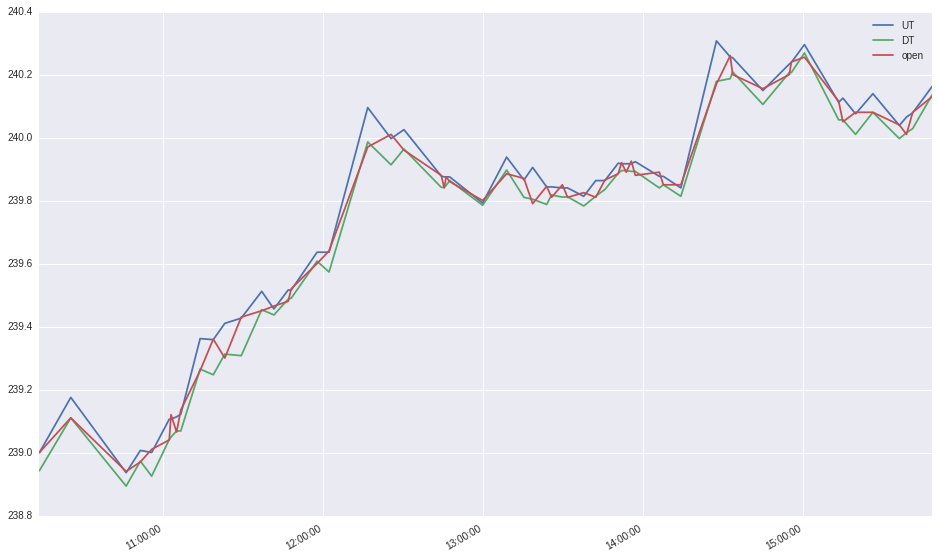

In [40]:
df[['UT','DT','open']].tail(60).plot(figsize=(16, 10))
plt.show()

In [56]:

X1=pd.DataFrame(df_ml[['speed','spread','e','S','R']]).tail(1000)
X1['Y1']=svm_model.predict(X1)
X1['BS']=df_ml.BS

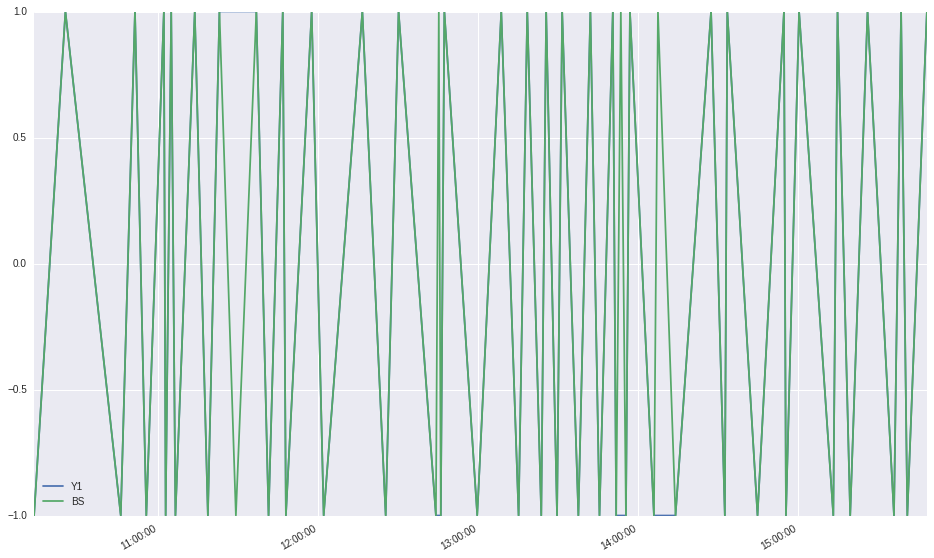

In [57]:
X1[['Y1','BS']].tail(60).plot(figsize=(16, 10))
plt.show()